In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline
from scipy import stats
from statsmodels.stats.descriptivestats import sign_test
import scipy
from statsmodels.stats.weightstats import *
from statsmodels.stats.proportion import proportion_confint
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('credit_default.csv')

In [3]:
df.head(10)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
5,6,50000,1,1,2,37,0,0,0,0,...,19394,19619,20024,2500,1815,657,1000,1000,800,0
6,7,500000,1,1,2,29,0,0,0,0,...,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
7,8,100000,2,2,2,23,0,0,0,0,...,221,-159,567,380,601,0,581,1687,1542,0
8,9,140000,2,3,1,28,0,0,2,0,...,12211,11793,3719,3329,0,432,1000,1000,1000,0
9,10,20000,1,3,2,35,0,0,0,0,...,0,13007,13912,0,0,0,13007,1122,0,0


# Задание 1

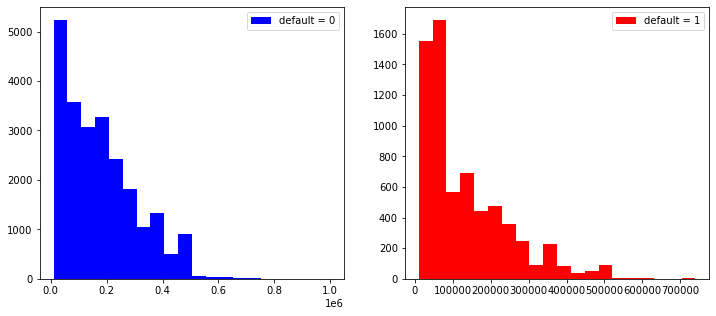

In [4]:
pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
pylab.hist(df[df.default == 0].LIMIT_BAL, bins = 20, color = 'b', label = 'default = 0')
pylab.legend()

pylab.subplot(1,2,2)
pylab.hist(df[df.default == 1].LIMIT_BAL, bins = 20, color = 'r',  label = 'default = 1')
pylab.legend()

pylab.show()

### 1.а. Гопотеза о равенсве медиан

Н0: Медианы на двух подвыборках равны

Н1: Медианы на двух подвыборках не равны

In [5]:
print('Медиана лимита для тех, кто вернул кредит равна', df[df.default == 0].LIMIT_BAL.median())
print('Медиана лимита для тех, кто НЕ вернул кредит равна', df[df.default == 1].LIMIT_BAL.median())

Медиана лимита для тех, кто вернул кредит равна 150000.0
Медиана лимита для тех, кто НЕ вернул кредит равна 90000.0


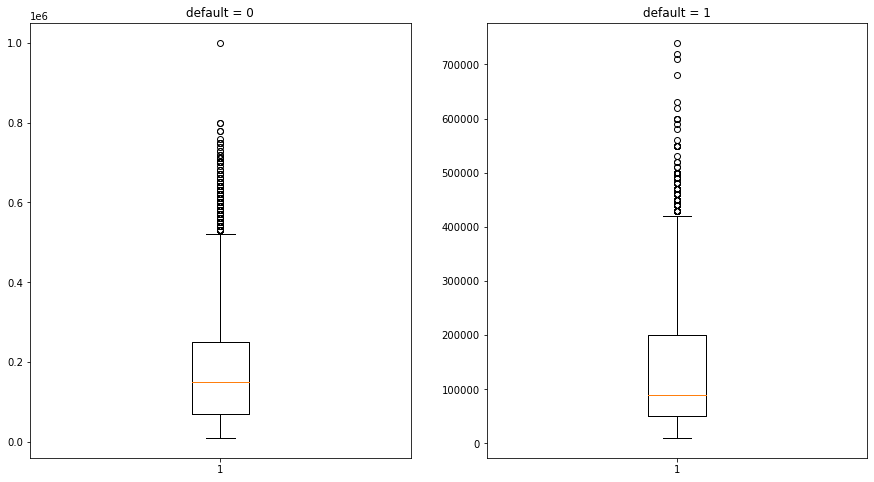

In [6]:
fig, ax = plt.subplots(1,2, figsize = (15, 8))
ax[0].boxplot(df[df.default == 0].LIMIT_BAL)
ax[1].boxplot(df[df.default == 1].LIMIT_BAL)
ax[0].set_title('default = 0')
ax[1].set_title('default = 1');

На ящиковых диаграмма видно, то медиана лимита у недефолтных клиентов раположена немного выше

Построим интервальную оценку для медианы с помощью бутстрапа.

In [7]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [8]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [9]:
limit_default = df[df.default == 1].LIMIT_BAL.values
limit_non_default = df[df.default == 0].LIMIT_BAL.values

In [10]:
np.random.seed(0)

ld_median_scores = list(map(np.median, get_bootstrap_samples(limit_default, 1000)))
lnd_median_scores = list(map(np.median, get_bootstrap_samples(limit_non_default, 1000)))

print("95% confidence interval for the default median LIMIT BAL:",  stat_intervals(ld_median_scores, 0.05))
print("95% confidence interval for the non-default median LIMIT BAL:",  stat_intervals(lnd_median_scores, 0.05))

95% confidence interval for the default median LIMIT BAL: [80000. 90000.]
95% confidence interval for the non-default median LIMIT BAL: [150000. 150000.]


Из результатов видим, что доверительные интервалы для кредитного лимита в двух подвыборках не пересекаются, на основании чего можно ОТКЛОНИТЬ гипотезу о равенстве медиан для дех кто вернул и не вернул кредит.

### 1.б. Гипотеза о равенстве распределений

In [11]:
#stats.mannwhitneyu(limit_default, limit_non_default)

Н0: Распределения двух групп заемщиков равны

Н1: Распределения двух групп не равны

Воспользуемся для проверки данной гипотезы перестановоччным критерием

In [12]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [13]:
def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [14]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

In [15]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [16]:
print("p-value:", permutation_test(limit_default, limit_non_default, max_permutations = 10000))

p-value: 0.0001


Значение p-value меньше 0.05 позволяет отклонить нулевую гиотезу. Значит, распределения подвыборок различаются. Данный результ имеет практическую значимость, так как разница довольно высока. Кредитный лимит для тех, ктовернул кредит выше.

# Задание 2

Переобозначим категории в переменной SEX, чтобы было удобнее сччитать доли.

(0 = мужской, 1 = женский )

In [17]:
df.loc[df.SEX == 1, 'SEX'] = 0 # Мужчины
df.loc[df.SEX == 2, 'SEX'] = 1 # Женщины

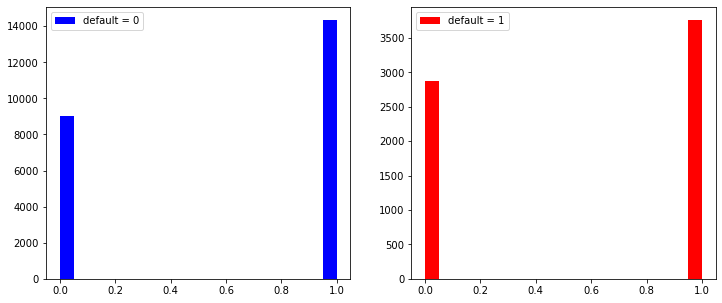

In [18]:
pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
pylab.hist(df[df.default == 0].SEX, bins = 20, color = 'b', label = 'default = 0')
pylab.legend()

pylab.subplot(1,2,2)
pylab.hist(df[df.default == 1].SEX, bins = 20, color = 'r',  label = 'default = 1')
pylab.legend()

pylab.show()

In [19]:
print('Доля женщин в числе вернувших кредит = ', df[df.default == 0].SEX.mean())
print('Доля женщин в числе НЕ вернувших кредит = ', df[df.default == 1].SEX.mean())

Доля женщин в числе вернувших кредит =  0.6141499743194658
Доля женщин в числе НЕ вернувших кредит =  0.5670584689572031


На первый взгляд, доля женщин в группе вернувших кредит немного выше, то есть гендерный состав подвыборок несколько отличается. Проверим, зачимо ли это различие статистически.

### Интервальная оценка разности долей в двух подвыборках

In [20]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)   
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [21]:
print("confidence interval: [%f, %f]" % proportions_confint_diff_ind(df[df.default == 0].SEX, df[df.default == 1].SEX))

confidence interval: [0.033635, 0.060548]


Доверительный интервал не включает ноль, что может говорить о наличие статистического отличия в гендерном составе двух подвыборок.

### Оценка разности долей с помощью Z-критерия

Н0: Гендерный состав групп не отличается (доли женщин в подвыборках не отличаются)

Н1: Гендерный состав грууп отличается (доли не равны)

In [22]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [23]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [24]:
print("p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(df[df.default == 0].SEX, df[df.default == 1].SEX)))

p-value: 0.000000


P-value оказалось равным нулю, что позволяет отклонить нулевую гипотезу о том, что доли не отлиаются, на 5% уровне значимости. Значит, гендерный состав тех, кто вернул и не вернул кредиты, действительно статистически различен. С практической точки зрения это говорит о том, что женщины являются немного более надежными заемщиками, чем мужчины (так как среди вернувших кредит доля женщин выше на 5%), но нельзя сказать. что это является очень весомым признаком в задаче скоринга.

# Задание 3

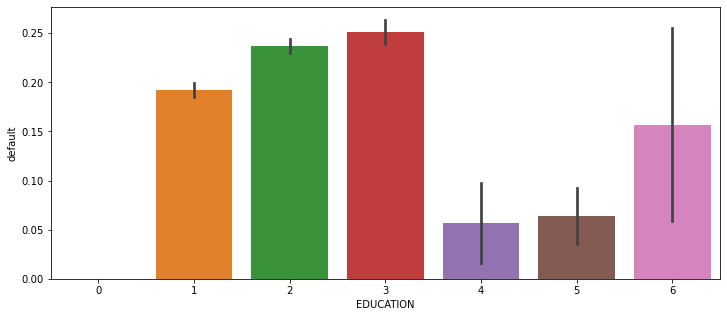

In [26]:
sns.barplot(x = 'EDUCATION', y = 'default', data = df);

In [30]:
df_educ_observed = pd.DataFrame(columns = ['def_0', 'def_1'], index=['educ_0', 'educ_1', 'educ_2', 'educ_3', 'educ_4', 'educ_5', 'educ_6'])
for j, d in zip(df_educ_observed.columns, [0,1]):
  for i, e in zip(df_educ_observed.index, [0,1,2,3,4,5,6]):
    df_educ_observed.loc[i, j] = df[(df.default == d)&(df.EDUCATION==e)].EDUCATION.count()
print('Таблица сопряженности для наблюдаемых значений')
df_educ_observed

Таблица сопряженности для наблюдаемых значений


,def_0,def_1
educ_0,14,0
educ_1,8549,2036
educ_2,10700,3330
educ_3,3680,1237
educ_4,116,7
educ_5,262,18
educ_6,43,8


In [31]:
_, p_val, _, educ_expected = scipy.stats.chi2_contingency(np.array(df_educ_observed))

In [32]:
new_table = pd.DataFrame(np.array(df_educ_observed) - educ_expected, columns = ['def_0', 'def_1'], index=['educ_0', 'educ_1', 'educ_2', 'educ_3', 'educ_4', 'educ_5', 'educ_6'])
print('Таблица сопряженности для разности наблюдаемых и ожидаемых значений')
new_table

Таблица сопряженности для разности наблюдаемых и ожидаемых значений


,def_0,def_1
educ_0,3.0968,-3.0968
educ_1,305.402,-305.402
educ_2,-226.564,226.564
educ_3,-149.36,149.36
educ_4,20.2076,-20.2076
educ_5,43.936,-43.936
educ_6,3.2812,-3.2812


Для модификации данной таблицы, чтобы привести ее к единому масштабу, можно поделить значения на ожидаемые значения:

In [33]:
new_table_modified = new_table/educ_expected
new_table_modified

,def_0,def_1
educ_0,0.284027,-1
educ_1,0.0370472,-0.130436
educ_2,-0.0207352,0.0730042
educ_3,-0.0390038,0.137324
educ_4,0.210952,-0.742719
educ_5,0.201482,-0.709377
educ_6,0.0826108,-0.290856


Н0: Образование не влияет на возврат кредита

Н1: Образование влияет на возврат кредита

In [34]:
print('p-value = ', p_val)

p-value =  1.2332626245415605e-32


Нулевая гипотеза отвргается (р-значение меньше 0.05), значит, можем сделать вывод, что есть статистически значимая корреляция между уровнем образования и возвратом кредита. 

Также по столбиковой диарамме можно сказать, что наличие докторской степени является наилучшим индикатором, что человек вернет долг, так как среди таких людей не было тех, кто дефолтил. Индикатор образования "выпускник школы" напротив является индикатором того, что человек с высокой вероятностью может не вернуть долг.

# Задание 4

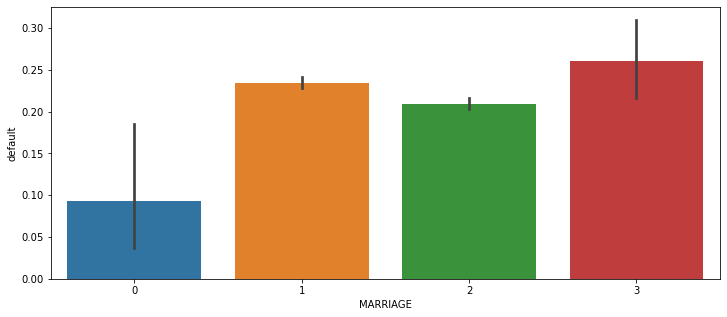

In [35]:
sns.barplot(x = 'MARRIAGE', y = 'default', data = df);

In [36]:
df_marriage = pd.pivot_table(df, values = 'ID', aggfunc = 'count', index = 'MARRIAGE', columns = 'default', fill_value=0)
df_marriage

default,0,1
MARRIAGE,,
0,49,5
1,10453,3206
2,12623,3341
3,239,84


In [37]:
chi2, p_val, _, _ = scipy.stats.chi2_contingency(np.array(df_marriage))

Н0: Корреляция статистически не значима

Н1: Корреляция статистически значима

In [38]:
n = df.shape[0]
corr_Kramer = np.sqrt(chi2 / (n*(2-1)))
print('Коэффициент корреляции Крамера =', corr_Kramer)
print('p_value =', p_val)

Коэффициент корреляции Крамера = 0.034478203662766466
p_value = 8.825862457577375e-08


Р-значение меньше 0.05, что позволяет отклонить нулевую гипотезу о незначимости корреляции. Однако практически данная корреляция не имеет смысла, так как она очень близка к нулю.

# Задание 5

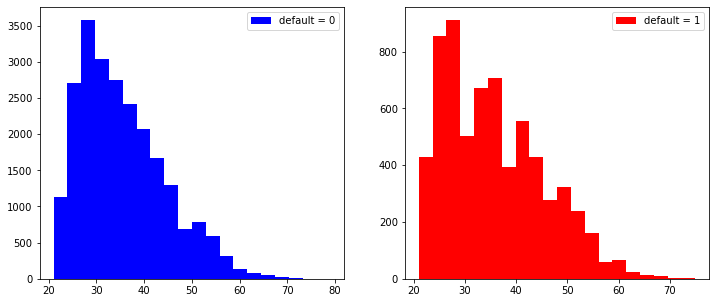

In [39]:
pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
pylab.hist(df[df.default == 0].AGE, bins = 20, color = 'b', label = 'default = 0')
pylab.legend()

pylab.subplot(1,2,2)
pylab.hist(df[df.default == 1].AGE, bins = 20, color = 'r',  label = 'default = 1')
pylab.legend()

pylab.show()

In [40]:
print('Медиана возраста для тех, кто вернул кредит равна', df[df.default == 0].AGE.median())
print('Медиана возраста для тех, кто НЕ вернул кредит равна', df[df.default == 1].AGE.median())

Медиана возраста для тех, кто вернул кредит равна 34.0
Медиана возраста для тех, кто НЕ вернул кредит равна 34.0


In [41]:
age_default = df[df.default == 1].AGE.values
age_non_default = df[df.default == 0].AGE.values

In [42]:
np.random.seed(0)

ad_median_scores = list(map(np.median, get_bootstrap_samples(age_default, 1000)))
and_median_scores = list(map(np.median, get_bootstrap_samples(age_non_default, 1000)))

print("95% confidence interval for the default median LIMIT BAL:",  stat_intervals(ad_median_scores, 0.05))
print("95% confidence interval for the non-default median LIMIT BAL:",  stat_intervals(and_median_scores, 0.05))

95% confidence interval for the default median LIMIT BAL: [34. 35.]
95% confidence interval for the non-default median LIMIT BAL: [34. 34.]


Доверительный интервал для возраста среди тех, кто вернул кредит, лежит внутри доверительного интервала для тех, кто не вернул кредит. Исходя из полученного результата, мы не можем сделать вывод о различии медиан в подвыборках.

### 5.б. Гипотеза о равенстве распределений

Н0: Распределения равны

Н1: Распределения не равны

проверка с помощью перестановочного критерия

In [43]:
print("p-value:", permutation_test(age_default, age_non_default, max_permutations = 10000))

p-value: 0.0184


Р-значение меньше 0.05, что позволяет отклонить нулевую гипотезу, значит распределения статистически отличаются. Однако с практической точки зрения результаты не кажутся значимыми, так как выборочные средние значения совпадают.